In [39]:
import numpy as np
import matplotlib.pyplot as plt
import h5py

In [101]:
# open the data file
with h5py.File('../CodePass2/runs/iwantit2worknow.hdf5', 'r') as f:
    # read the data
    x = f['x'][:]
    properties = f['properties'][:]
 

# find voronoi diagram
from scipy.spatial import Delaunay, cKDTree


# def get_nbs(xs) -> set:
#     tri = Delaunay(xs)
#     indsx, all_neighbors = tri.vertex_neighbor_vertices

#     neighbors = []
#     for i in range(len(indsx)-1):
#         neighbors.append(set(all_neighbors[indsx[i]:indsx[i+1]]))

#     return neighbors

def get_nbs(x):
    def find_potential_neighbours(x, k=100, distance_upper_bound=np.inf, workers=-1):
        tree = cKDTree(x)
        d, idx = tree.query(x, k + 1, distance_upper_bound=distance_upper_bound, workers=workers)
        return d[:, 1:], idx[:, 1:]

    def find_true_neighbours(d, dx):
        z_masks = []
        i0 = 0
        batch_size = 250
        i1 = batch_size
        while True:
            if i0 >= dx.shape[0]:
                break

            n_dis = np.sum((dx[i0:i1, :, None, :] / 2 - dx[i0:i1, None, :, :]) ** 2, axis=3)
            n_dis += 1000 * np.eye(n_dis.shape[1])[None, :, :]

            z_mask = np.sum(n_dis < (d[i0:i1, :, None] ** 2 / 4), axis=2) <= 0 #seethru
            z_masks.append(z_mask)

            if i1 > dx.shape[0]:
                break
            i0 = i1
            i1 += batch_size
        z_mask = np.concatenate(z_masks, axis=0)
        return z_mask
    
    d, idx = find_potential_neighbours(x)
    dx = x[:, None, :] - x[idx]


    mask = find_true_neighbours(d, dx)

    return [set(idx[i][mask[i]]) for i in range(len(x))]

In [102]:
iii = 0
nbs_0 = get_nbs(x[iii*1])
nbs_1 = get_nbs(x[(iii+1)*1])



In [105]:
nbs_0[0]

{12, 2911, 2997, 3814, 4973}

(array([275., 399., 487., 554., 597., 622., 616., 574., 506., 370.]),
 array([-79.91615295, -65.92959595, -51.94303513, -37.95647812,
        -23.96992111,  -9.9833622 ,   4.00319576,  17.98975372,
         31.97631264,  45.96287155,  59.94942856]),
 <BarContainer object of 10 artists>)

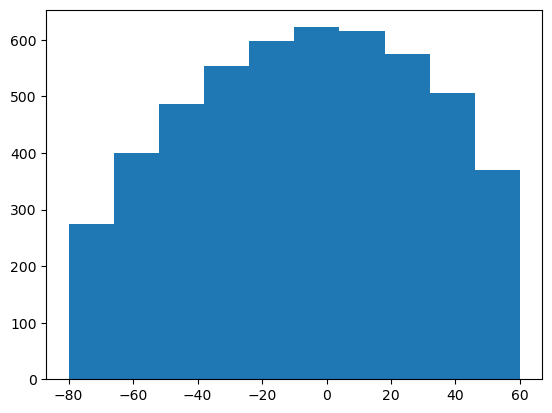

In [12]:
plt.hist(x[0,:,0])

In [8]:
x.shape

(1401, 5000, 3)

In [11]:
properties.shape

(5000,)

In [108]:
x.shape

(1401, 5000, 3)

In [142]:

N_steps = int(x.shape[0] / 100)
counts = np.zeros((N_steps, x.shape[1]))

# gband = x[gband_mask]

vecs = []
poss = []



scl = 100
for iii in range(N_steps):

    xx0 = x[iii*scl]
    xx1 = x[iii*scl+scl]


    # xx1 = xx1[xx0[:,2] < 0]
    # xx0 = xx0[xx0[:,2] < 0]

    nbs_0 : list[set] = get_nbs(xx0)
    nbs_1 : list[set] = get_nbs(xx1)

    pairs = []

    for i in range(len(nbs_0)):
        if properties[0][i] not in (0, 1):
            continue

        if xx0[i,2] > 0:
            continue
        
        shouldbreak = False
        new_nbs = nbs_1[i] - nbs_0[i]
        for new_nb in new_nbs:
            if set([i, new_nb]) in pairs:
                continue
            pairs.append(set([i, new_nb]))


            dist = np.array([np.linalg.norm(x[iii*scl+ scl,i] - x[iii*scl+scl,new_nb])])

            if dist > 6:
                continue

            nb_nbs = nbs_1[new_nb]
            overlap = nb_nbs & nbs_1[i]
            
            for common_nb in overlap:
                common_ns_prev_nbs = nbs_0[common_nb]
                common_nb_new_nbs = nbs_1[common_nb]

                overlapx2 = (common_ns_prev_nbs - common_nb_new_nbs) & overlap 

                if len(overlapx2) > 0:
                    counts[iii, i] += 1
                    vec_between = x[iii*scl+scl,common_nb] - x[iii*scl+scl,list(overlapx2)[0]]
                    vecs.append(vec_between)

                    poss.append(x[iii*scl,i])
                    shouldbreak = True
                    break

            if shouldbreak:
                break



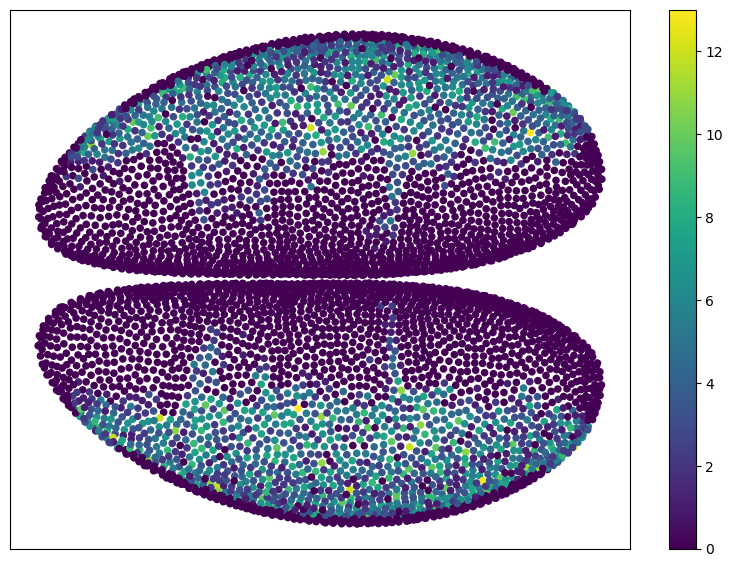

In [153]:
sumcount = np.sum(counts, axis=0)

xx, yy, zz = x[2,:,0], x[2,:,1], x[2,:,2]

plt.figure(figsize=(10,7))
plt.scatter(xx[yy<0], zz[yy<0], c = sumcount[yy<0], s=20)
plt.scatter(xx[yy>0], -zz[yy>0] + + 55, c = sumcount[yy>0], s=20)
plt.colorbar()
# remove ticks
plt.xticks([])
plt.yticks([])
plt.show()

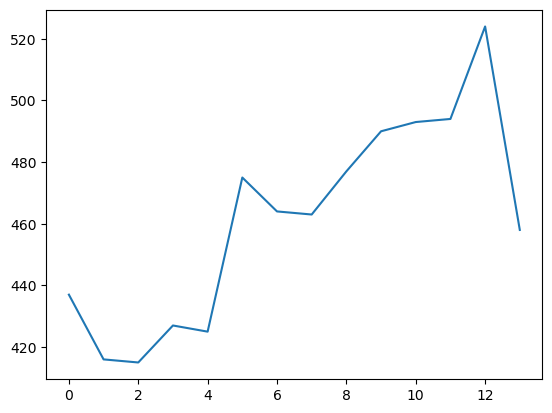

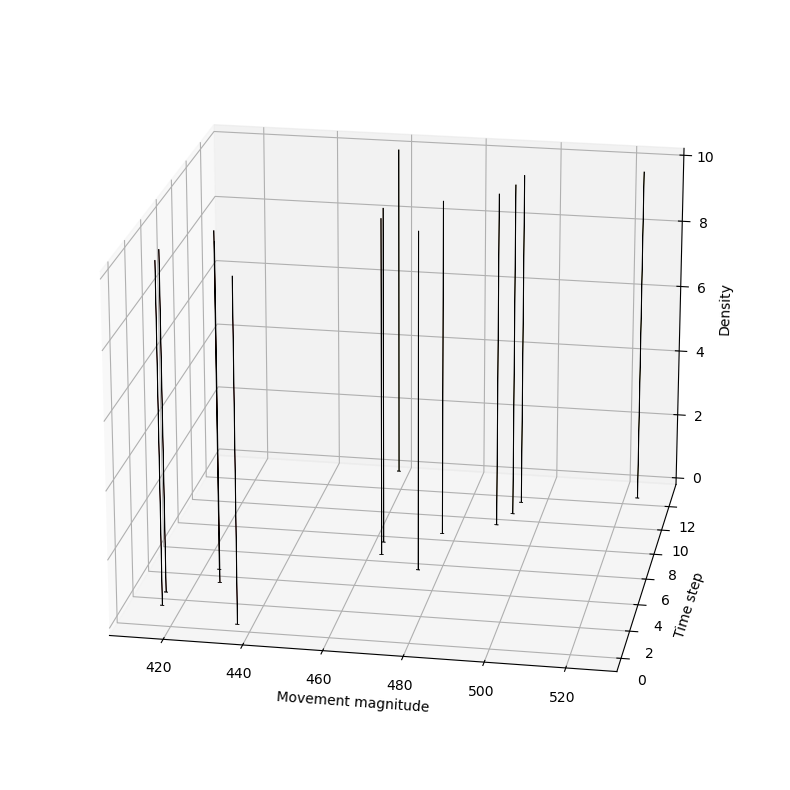

In [123]:
sumcount = np.sum(counts, axis=1)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')


for t in range(len(sumcount)):

    bins, edges = np.histogram(sumcount[t], bins=10, density=True)

    ax.bar(edges[:-1], bins, zs=t, zdir='y', alpha=1, color=(1, t/(len(sumcount)), 0), width=0.1, edgecolor = "black", linewidth=.5)

ax.set_xlabel("Movement magnitude")
ax.set_ylabel("Time step")
ax.set_zlabel("Density")

# change the view angle
ax.view_init(elev=20, azim=-80)


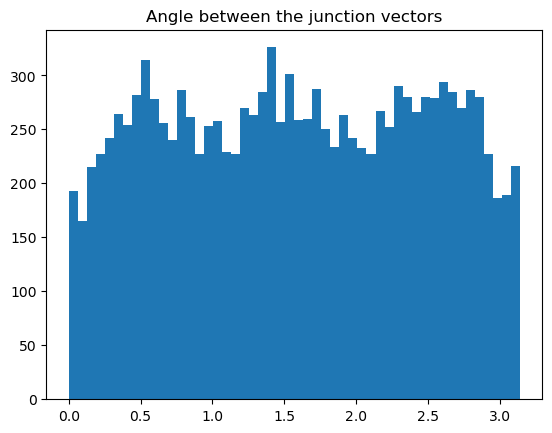

In [69]:
poss = np.array(poss)
gb_mask = (poss[:,2] > -20)* (poss[:,2] < 20) * (poss[:,0] > -50) * (poss[:,0] < 50)

vecs_arr = np.array(vecs)[gb_mask][1000:20000]

# plot histogram of their directions
plt.hist(np.abs(np.arctan2(vecs_arr[:,2], vecs_arr[:,0])), bins=50)
plt.title('Angle between the junction vectors')
plt.show()

Text(0.5, 0, 'Time')

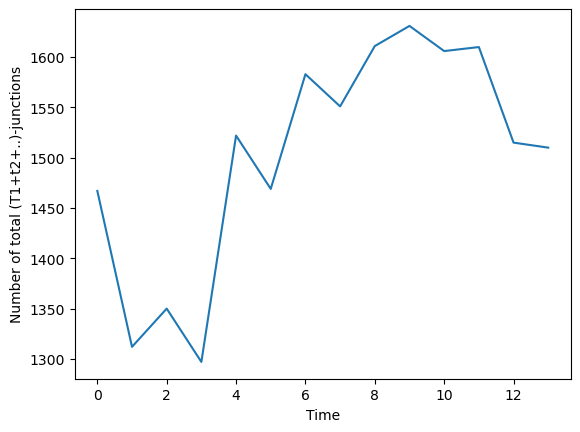

In [70]:
plt.plot(countss)
plt.ylabel("Number of total (T1+t2+..)-junctions")
plt.xlabel("Time")

In [13]:
count_dict = {}
for cc in countss:
    unique, counts = np.unique(cc, return_counts=True)
    for u, c in zip(unique, counts):
        if u not in count_dict:
            count_dict[u] = [c]
        else:
            count_dict[u] += [c]


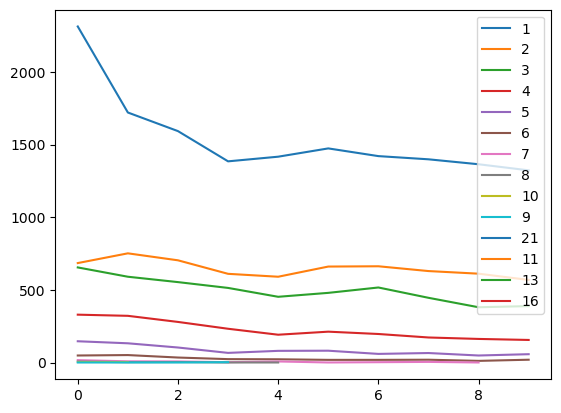

In [14]:


for key in count_dict:
    if key == 0:
        continue
    plt.plot(count_dict[key], label=key-1)

plt.legend()
plt.show()

33 found


array([ 22.55915362,  22.794821  ,  23.93053778,  25.54184046,
        26.07021809,  30.18249583,  31.30950421,  32.8371011 ,
        33.18123804,  34.92333912,  35.04652951,  36.74293901,
        38.53769274,  41.47515546,  44.25340306,  46.01084854,
        48.56713499,  50.21158842,  53.083425  ,  55.23214374,
        57.09042487,  59.06500152,  62.06215945,  63.64076801,
        65.14520202,  67.52690187,  69.8265413 ,  70.06714742,
        75.57376205,  90.41398978,  94.4971932 ,  99.46832406,
       110.8979863 ])